# Проект
В рамках работы над проектом для компании, разрабатывающей мобильные игры, мне были поставлены несколько задач, касающихся анализа различных аспектов мобильного приложения:

В первую очередь, менеджер заинтересовался показателем retention (удержания пользователей). Нужно разработать функцию для подсчета этого показателя, которая позволяет вычислять процент пользователей, вернувшихся в игру через определённый промежуток времени после первого использования.

В компании было проведено A/B тестирование различных акционных предложений. На основе полученных данных нужно определить, какое предложение показывает лучшие результаты и на основе каких метрик стоит принять правильное решение.
    
В связи с прошедшим тематическим событием в игре, мне было поручено предложить метрики для оценки его успеха. 

In [128]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [129]:
# Читаем данные
reg_data = pd.read_csv('problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('problem1-auth_data.csv', sep=';')

# Задание 1
**Retention** – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

In [130]:
# Проведем разведочный анализ, а также подготовим данные для дальнейшей работы.

In [131]:
reg_data

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [132]:
auth_data

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


In [133]:
reg_data.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

In [134]:
auth_data.nunique()

auth_ts    9180915
uid        1000000
dtype: int64

In [135]:
# Как видим, количество уникальных пользователей 1млн

In [136]:
# Найдем пропущенные значения

In [137]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [138]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [139]:
# Найдем дубликаты

In [140]:
reg_data.duplicated().sum()

0

In [141]:
auth_data.duplicated().sum()

0

In [142]:
 #Переведем время регистрации и авторизации в удобный для дальнейшего анализа формат.

In [143]:
#В формат datetime для вычислений в когортном анализе
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s')
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s')

In [144]:
#В формат period для удобства визуализации
reg_data['reg_day']= reg_data['reg_ts'].dt.to_period('D')
auth_data['auth_day']= auth_data['auth_ts'].dt.to_period('D')

In [145]:
reg_data.head()

,reg_ts,uid,reg_day
0,1998-11-18 09:43:43,1,1998-11-18
1,1999-07-22 22:38:09,2,1999-07-22
2,2000-01-13 22:27:27,3,2000-01-13
3,2000-05-28 14:19:01,4,2000-05-28
4,2000-09-16 11:21:53,5,2000-09-16


In [146]:
auth_data.head()

,auth_ts,uid,auth_day
0,1998-11-18 09:43:43,1,1998-11-18
1,1999-07-22 22:38:09,2,1999-07-22
2,1999-07-25 16:46:46,2,1999-07-25
3,1999-07-31 03:50:15,2,1999-07-31
4,1999-08-05 17:49:39,2,1999-08-05


In [147]:
# Визуализируем данные для общего представления

Text(0.5, 0, 'Дни')

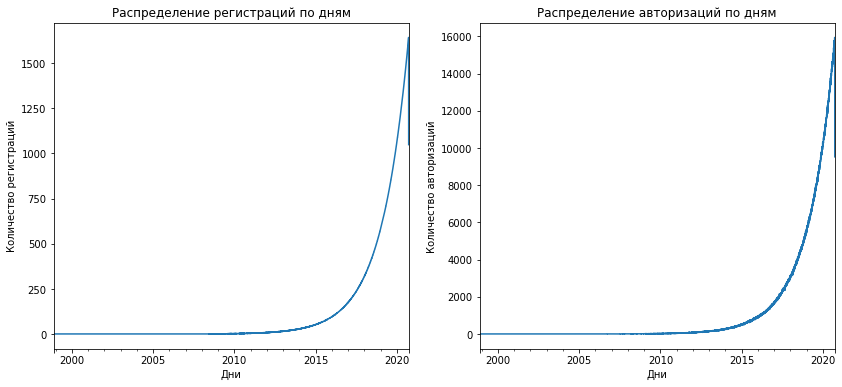

In [148]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
reg_data.groupby('reg_day').uid.count().plot(ax=axes[0])
axes[0].set_title("Распределение регистраций по дням")
axes[0].set_ylabel("Количество регистраций")
axes[0].set_xlabel("Дни")


auth_data.groupby('auth_day').uid.count().plot(ax=axes[1])
axes[1].set_title("Распределение авторизаций по дням")
axes[1].set_ylabel("Количество авторизаций")
axes[1].set_xlabel("Дни")

In [149]:
# Посчитаем частоту авторизация на пользователя
frequency_auth = auth_data.auth_ts.count() / auth_data.uid.nunique()
print(f"Частота авторизаций на пользователя: {frequency_auth.round(1)}")

Частота авторизаций на пользователя: 9.6


In [150]:
# Графики схожи друг с другом. Количество регистрация и авторизация растет с течением времени.
# Активный рост начался с 2017 года.

In [151]:
# Напишем функцию по построению тепловой карты удержания пользователей (retention rate)

In [152]:
def daily_retention_rate(reg_data: pd.DataFrame, auth_data: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Параметры, которые передаются функции:
    reg_data - датафрейм с данными регистраций
    auth_data - датафрейм с данными авторизаций
    start_date, end_date - диапозон интересующих нас дат в формате "YYYY-MM-DD"
    
    """
    # Преобразуем интересующий нас диапозон дат в формат Period
    start_date = pd.to_datetime(start_date).to_period('D')
    end_date = pd.to_datetime(end_date).to_period('D')
    
    # Создаем новые датафреймы фильтруя по диапозону дат
    reg_new = reg_data[(reg_data['reg_day'] >= start_date) & (reg_data['reg_day'] <= end_date)].copy()
    auth_new = auth_data[(auth_data['auth_day'] >= start_date) & (auth_data['auth_day'] <= end_date)].copy()
    
    # Создаем когорты по дате регистрации
    reg_new['cohort'] = reg_new['reg_ts'].dt.to_period('D')
    
    # Мержим 2 датафрейма по uid (уникальному айди пользователя)
    merged_data = pd.merge(reg_new, auth_new, on='uid', how='left')
    
    # Добавляем столбец с разницей между днем авторизации и днем регистрации
    merged_data['days_since_registration'] = (merged_data['auth_ts'] - merged_data['reg_ts']).dt.days
    
    # Фильтруем пользователей, которые авторизовались после регистрации
    merged_data = merged_data[merged_data['days_since_registration'] >= 0]
    
    # Считаем количество пользователей по когортам и дням
    cohort_data = merged_data.groupby(['cohort', 'days_since_registration'])['uid'].nunique().reset_index()
    
    # Считаем количество пользователей в каждой когорте
    cohort_sizes = reg_new.groupby('cohort')['uid'].nunique().reset_index()
    cohort_sizes.rename(columns={'uid': 'cohort_size'}, inplace=True)
    
    # Мержим количество пользователей в каждой когорте с данными по авторизациям
    cohort_data = pd.merge(cohort_data, cohort_sizes, on='cohort')
    
    # Рассчитываем retention rate
    cohort_data['retention_rate'] = cohort_data['uid'] / cohort_data['cohort_size']
    
    # Пивотируем данные, чтобы получить тепловую карту
    cohort_pivot = cohort_data.pivot(index='cohort', columns='days_since_registration', values='retention_rate')
    
    # Удаляем столбец с 0 днем (день регистрации)
    cohort_pivot = cohort_pivot.drop(columns=[0], errors='ignore')
    
    # Строим тепловую карту
    plt.figure(figsize=(20, 16))
    sns.heatmap(cohort_pivot, annot=True, fmt=".1%", cmap='YlGnBu', cbar=True)
    plt.title('Тепловая карта удержания клиентов')
    plt.xlabel('Дней со дня регистрации')
    plt.ylabel('Когорта')
    plt.tight_layout()
    plt.show()
    
    # Получаем медианный retention rate для 1-го дня
    first_day_data = cohort_data[cohort_data['days_since_registration'] == 1]
    median_first_day_retention = first_day_data['retention_rate'].median()

    # Выводим медианный retention rate для 1-го дня
    print(f"Медианный retention rate первого дня: {median_first_day_retention:.2%}")

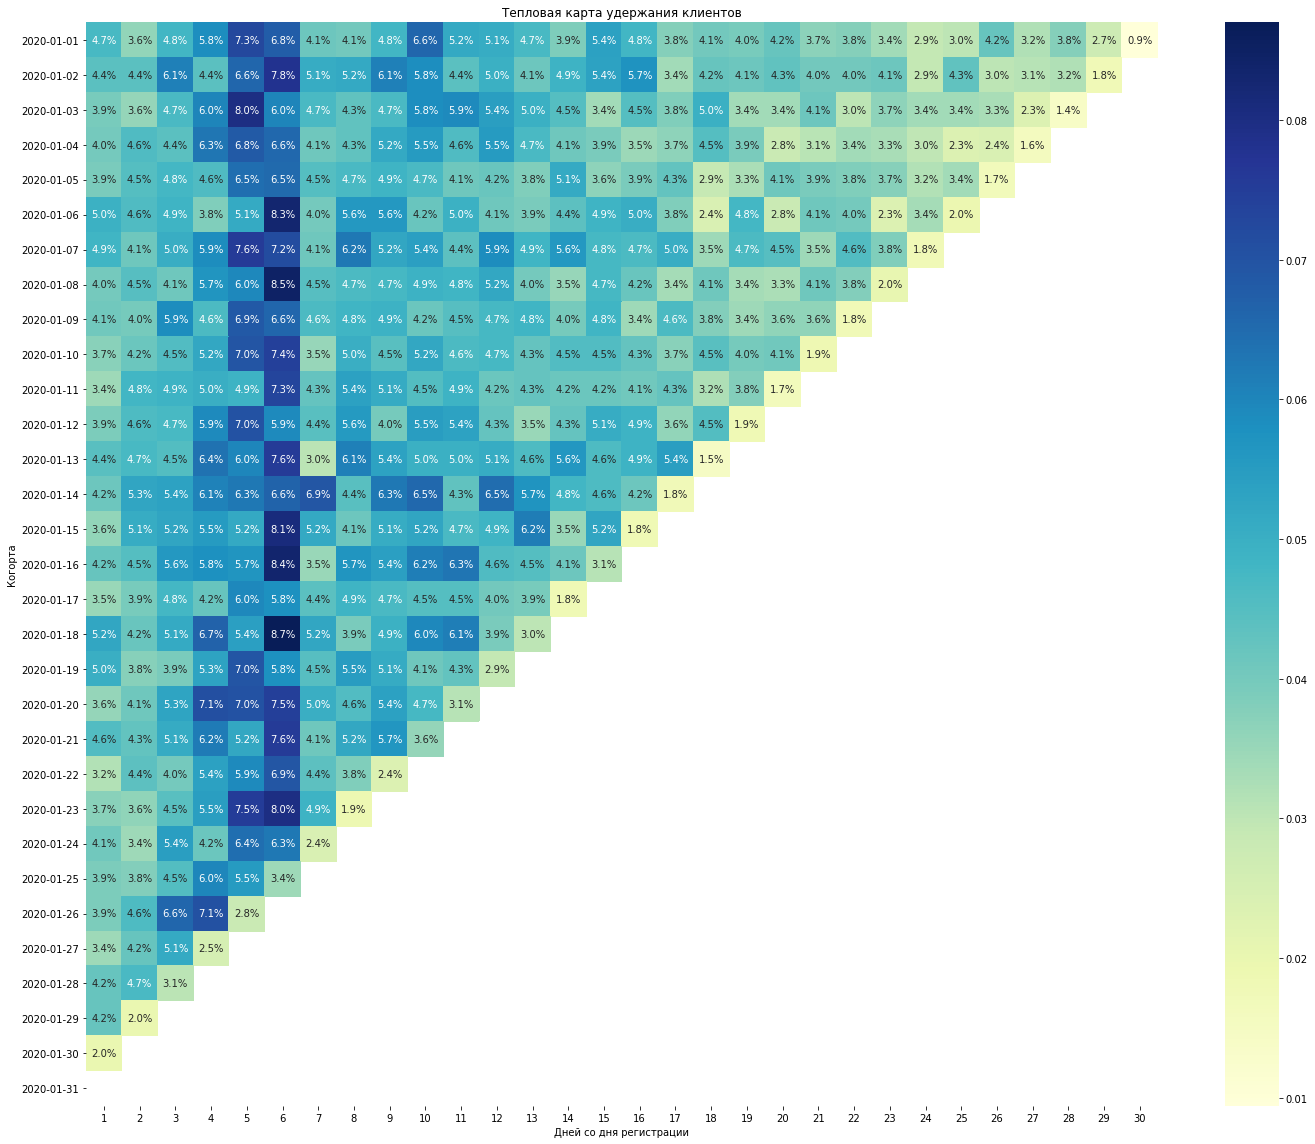

Медианный retention rate первого дня: 4.02%


In [153]:
# Выводим тепловую карту, задав интересующий нас диапозон дат
daily_retention_rate(reg_data, auth_data, '2020-01-01', '2020-01-31')

**Вывод**: Низкий показатель **retention rate** указывает на отсутствие **product/market fit**. Т.е. продукт не покрывает потребность клиента в данном сегменте.

# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Перед тем как определить ключевые метрики, взглянем на наши данные, вычислим метрики Revenue, ARPU, ARPPU и Conversion Rate.

In [154]:
# Проведем разведочный анализ, а также подготовим данные для дальнейшей работы.

In [155]:
ab_test = pd.read_csv('Проект_1_Задание_2.csv', sep=';')

In [156]:
ab_test

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [157]:
ab_test.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [158]:
# Переводим тип переменной user_id в object
ab_test['user_id'] = ab_test.user_id.astype('object')

In [159]:
# Найдем пропущенные значения
ab_test.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [160]:
# Найдем дубликаты
ab_test.duplicated().sum()

0

In [161]:
# Сделаем 2 датафрейма разбив пользователей по группам
# Контрольная группа
control_group = ab_test.query("testgroup == 'a'")
# Тестовая группа
test_group = ab_test.query("testgroup == 'b'")

In [162]:
# Найдем количество платящих пользователей в контрольной группе
print(f"Количество платящих пользователей в контрольной группе: {control_group.query('revenue > 0').user_id.count()}")

# Найдем количество платящих пользователей в тестовой группе
print(f"Количество платящих пользователей в тестовой группе: {test_group.query('revenue > 0').user_id.count()}")

Количество платящих пользователей в контрольной группе: 1928
Количество платящих пользователей в тестовой группе: 1805


In [163]:
# Сравним revenue двух групп
# Вычислим общий доход в контрольной группе (revenue)
print(f"Общий доход в контрольной группе: {control_group.revenue.sum()}")

# Вычислим общий доход в тестовой группе (revenue)
print(f"Общий доход в тестовой группе: {test_group.revenue.sum()}")

Общий доход в контрольной группе: 5136189
Общий доход в тестовой группе: 5421603


In [164]:
# Сделаем 1 датафрейм с метриками, которые нас интересуют
metrics = ab_test.groupby('testgroup')\
               .agg(total_users=('user_id', 'count'),
                    paying_users=('revenue', lambda x: (x > 0).sum()),
                    total_revenue=('revenue', 'sum'))

In [165]:
metrics

,total_users,paying_users,total_revenue
testgroup,,,
a,202103,1928,5136189
b,202667,1805,5421603


In [166]:
# Найдем средний доход на пользователя (ARPU)
metrics['ARPU'] = np.round(metrics.total_revenue / metrics.total_users, 1)
# Найдем средний доход на платящего пользователя (ARPPU)
metrics['ARPPU'] = np.round(metrics.total_revenue / metrics.paying_users, 2)
# Найдем конверсию в платящего пользователя (Conversion Rate)
metrics['CR'] = np.round(metrics.paying_users / metrics.total_users * 100, 2)

In [167]:
metrics

,total_users,paying_users,total_revenue,ARPU,ARPPU,CR
testgroup,,,,,,
a,202103,1928,5136189,25.4,2664.00,0.95
b,202667,1805,5421603,26.8,3003.66,0.89


In [168]:
# Прежде чем переходить к стат тестам и проверке гипотез, проверим данные на выбросы.

In [169]:
# Взглянем на описательные характеристики контрольной и тестовых групп

In [170]:
control_group.describe()

,revenue
count,202103.000000
mean,25.413720
std,920.768137
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,37433.000000


In [171]:
test_group.describe()

,revenue
count,202667.000000
mean,26.751287
std,287.324162
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,4000.000000


In [172]:
# Бросается в глаза разница стандартном отклонении и  в максимальном значение revenue
# В дальнейшем анализе нужно проверить данные на выбросы, оценить как они влияют на группу и принять решение, что с ними делать.

In [173]:
# Используем boxplot для визуализации распределения revenue в группах

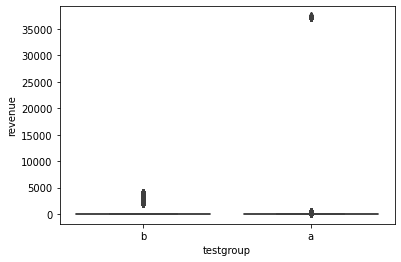

In [174]:
sns.boxplot(x='testgroup', y='revenue', data=ab_test)

In [175]:
# Согласно boxplot, видим, что в контрольной группе присутствуют выбросы.

In [176]:
# Используем статистический метод z-score для определения этих выбросов.

Формула Z-оценки:
z = (x - μ) / σ , 

где:

    X — значение наблюдения,

    μ — среднее значение контрольной группы,

    σ — стандартное отклонение контрольной группы.

In [177]:
mean_control = control_group.mean()
std_control = control_group.std()

# Рассчитываем Z-оценки для наблюдений в контрольной группе согласно формуле
z_scores = (control_group - mean_control) / std_control

# Устанавливаем порог для выбросов  Z > 3
anomaly_users = control_group[z_scores.abs() > 3]
anomaly_users = anomaly_users.query('revenue > 0')['revenue']

anomaly_users

416       37324.0
4428      37304.0
5777      37315.0
8065      37307.0
8743      37334.0
           ...   
360696    37347.0
378668    37297.0
389341    37298.0
394580    37302.0
399294    37321.0
Name: revenue, Length: 123, dtype: float64

In [178]:
# Находим количество выбросов
print(f"Количество выбросов: {anomaly_users.count()}")

Количество выбросов: 123


In [179]:
# Находим revenue этих пользователей
print(f"Общий доход пользователей: {anomaly_users.sum()}")

Общий доход пользователей: 4590252.0


In [180]:
# Находим ARPU этих пользователей
print(f"ARPU: {anomaly_users.mean().round(1)}")

ARPU: 37319.1


In [181]:
# Оценим влияние этих пользователей на общие значения контрольной группы.

In [182]:
# Вычислим долю пользователей (выбросов) в количестве платящих пользователей всей группы
round((anomaly_users.count() / control_group.query('revenue > 0').user_id.count() * 100), 2)

6.38

In [183]:
# Вычислим долю revenue выбросов в revenue всей группы
round((anomaly_users.sum() / control_group.revenue.sum() * 100), 2)

89.37

In [184]:
# Доля пользователей незначительна (6%), но доля revenue (89%) ставит вопрос о том, стоить ли учитывать данные выбросы или нет.

In [185]:
# Посмотрим на значения в контрольной группе, убрав выбросы.
anomaly_min = anomaly_users.min()
control_group_clear = control_group.query('revenue < @anomaly_min')
control_group_clear.describe()

,revenue
count,201980.000000
mean,2.702926
std,28.985815
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,400.000000


In [186]:
# Сделаем 1 датафрейм со всеми метриками, убрав выбросы
ab_test_clear = ab_test.query('revenue < @anomaly_min')
metrics_clear = ab_test_clear.groupby('testgroup')\
               .agg(total_users = ('user_id', 'count'),
                    paying_users = ('revenue', lambda x: (x > 0).sum()),
                    total_revenue = ('revenue', 'sum'))

In [187]:
# Найдем средний доход на пользователя (ARPU)
metrics_clear['ARPU'] = np.round(metrics_clear.total_revenue / metrics_clear.total_users, 1)
# Найдем средний доход на платящего пользователя (ARPPU)
metrics_clear['ARPPU'] = np.round(metrics_clear.total_revenue / metrics_clear.paying_users, 2)
# Найдем конверсию в платящего пользователя (Conversion Rate)
metrics_clear['CR'] = np.round(metrics_clear.paying_users / metrics_clear.total_users * 100, 2)

In [188]:
# Сравним значения метрик с включая выбросы и без

In [189]:
metrics_clear

,total_users,paying_users,total_revenue,ARPU,ARPPU,CR
testgroup,,,,,,
a,201980,1805,545937,2.7,302.46,0.89
b,202667,1805,5421603,26.8,3003.66,0.89


In [190]:
metrics

,total_users,paying_users,total_revenue,ARPU,ARPPU,CR
testgroup,,,,,,
a,202103,1928,5136189,25.4,2664.00,0.95
b,202667,1805,5421603,26.8,3003.66,0.89


В контрольной группе 123 пользователя (всего 6% платящих) принесли 89% дохода. Это говорит о том, что большая часть дохода в контрольной группе поступает от небольшой группы пользователей

Такие выбросы могут значительно исказить общую картину и могут быть не репрезентативными для всех пользователей. В идеале они не должны влиять на общий анализ, так как они могут не отражать поведение большинства игроков.

Контекст выбросов: Нужно убедиться, что выбросы — это не часть важной категории пользователей (например, лояльные игроки, которые могут быть стратегически важны для бизнеса).

Если цель предложения - это активно платящие клиентов (пользователи приносящие высокий доход), то выбросы стоит учитывать.
У нас недостаточно информации о роде акционных предложений и о категории данных пользователей (лояльные игроки или случайный выброс). 

На основе имеющихся данных предположим, что данный выброс обусловлен природой акционных предложений:
1. Набор акционных предложений в контрольной группе был ориентирован на повышение количества высокоплатящих пользователей (Например акции на дорогостоящие предметы в игре)
2. В то время как набор акционных предложений в тестовой группе был ориентирован на повышение среднего чека для большинства пользователей (Например акции на малостоящие, но востребованные предметы)

Для начала определим ключевые метрики, на которые должен ориентироваться продукт:

1. Целевая метрика **Средний доход на пользователя (ARPU)** - ключевая метрика для данного продукта, так как она прямо влияет на общий доход (Total Revenue) и легче тестировать статистически.


2. Прокси метрика **Средний доход на платящего пользователя (ARPPU)** - метрика, которая объясняет динамику ARPU. Если ARPPU растёт при стабильной конверсии, это говорит о успешной монетизации продукта.


3. Барьерная метрики **Конверсия в платящего (Conversion Rate)** - метрика, которую нельзя ухудшать. Её падение может компенсироваться ростом ARPPU, но если конверсия снижается критически, то это приведет к негативным последствиям для продукта..

***Оставляем выбросы и проведем статистические тесты***

**1. Проверка распределений на нормальность**

In [191]:
control = control_group.revenue
test = test_group.revenue

Формируем гипотезы:
    
   **H0**: данные группы распределены **нормально**   
   
   **H1**: данные группы распределены **ненормально**

In [192]:
# Проведем тест Пирсона

In [193]:
# Для контрольной группы
ss.normaltest(control)

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)

In [194]:
# Для тестовой группы
ss.normaltest(test)

NormaltestResult(statistic=326622.39540856465, pvalue=0.0)

Отвергаем нулевые гипотезы для обеих групп - распределения являются **ненормальными**.

**2.Проверка равенства дисперсий**

Формируем гипотезы:
    
   **H0**: дисперсии **не имеют** статистически значимых различий
   
   **H1**: дисперсии **имеют** статистически значимые различия

In [195]:
# Проведем тест Левена
levene_statistic, levene_p_value = ss.levene(control, test)

print(f"Statistic: {levene_statistic}")
print(f"P-Value: {levene_p_value}")

if levene_p_value < 0.05:
    print("Есть статистически значимое различие между группами.")
else:
    print("Нет статистически значимого различия между группами.")

Statistic: 0.3896289474701388
P-Value: 0.5324948591043842
Нет статистически значимого различия между группами.


Принимаем нулевую гипотезу, так как статистически значимых различий нет, т.е. дисперсии примерно равны.

Так как выборки являются достаточно большими и присутствуют выбросы, **t-тест Уэлча** несмотря на ненормальность распределений, подойдет для наших вычислений

**3. t-тест для ARPU**

   **H0**: ARPU двух групп **не имеют** статистически значимых различий   
   
   **H1**: ARPU двух групп **имеют** статистически значимые различия

In [198]:
# Проведем t-тест Уэлча
t_statistic, p_value = ss.ttest_ind(control, test)

print(f"Statistic: {t_statistic}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("Есть статистически значимое различие между группами.")
else:
    print("Нет статистически значимого различия между группами.")

Statistic: -0.6242026493616787
P-Value: 0.532494858971837
Нет статистически значимого различия между группами.


Принимаем нулевую гипотезу, как как две группы **не имеют** статистически значимые различия

**4. t-тест для ARPPU**

   **H0**: ARPU двух групп **не имеют** статистически значимых различий   
   
   **H1**: ARPU двух групп **имеют** статистически значимые различия

In [199]:
control_pay = control_group.query("revenue > 0").revenue
test_pay = test_group.query("revenue > 0").revenue

In [200]:
t_statistic, p_value = ss.ttest_ind(control_pay, test_pay)

print(f"Statistic: {t_statistic}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("Есть статистически значимое различие между группами.")
else:
    print("Нет статистически значимого различия между группами.")

Statistic: -1.5917100176862002
P-Value: 0.11153459157259504
Нет статистически значимого различия между группами.


Принимаем нулевую гипотезу, как как две группы **не имеют** статистически значимые различия

**5. Z-тест для конверсии (conversion rate)**

При большом размере выборки (200к в каждой группе) можно применить **Z-тест для пропорций** даже в случае, если данные имеют ненормальное распределение



   **H0**: Конверсии в двух группах **не имеют** стат значимых различий.

   **H1**: Конверсии в двух группах **имеют** стат значимые различия.

In [201]:
# Сделаем 2 перменные с платящими клиентами и общим количеством клиентов.
paying_users = metrics['paying_users']
total_users = metrics['total_users']

In [202]:
# Применим Z-тест для пропорций
z_statistic, p_value_cr = sm.stats.proportions_ztest(paying_users, total_users)
print(f"Z-статистика: {z_statistic}")
print(f"P-value: {p_value_cr}")

Z-статистика: 2.108028495889841
P-value: 0.035028524642854865


P-value меньше чем 0.05, соответственно отвергаем нулевую гипотезу. У конверсий двух групп есть стат значимые различия

Конверсия в контрольной группе превышает конверсию в тестовой группе и имеются стат значимые различия

# Общий вывод по A/B тесту


1. В контрольной группе присутствуют **выбросы** (клиенты с высоким **revenue**). Предположили, что данный выброс связан с природой акционных предложений (акция ориентированная на дорогостоящие покупки)


2. Определили, что для продукта в данном случае нужно сфокусироваться на метриках **ARPU, ARPPU, Conversion Rate**


3. На основе проведенных стат тестов, выяснили, что стат значимых различий в метриках **ARPU и ARPPU** нет. Однако Конверсия (Conversion Rate) в контрольной группе больше чем в тестовой (есть стат значимые различия). Так как метрика потенциально влияет на retentiont rate и отражает удовлетворенность продуктом, набор акционных предложений в контрольной группе можно считать лучшим


4. В идеале нужно **пересмотреть правильность проведения A/B теста**, так как наличие **экстремальных выбросов** и **значимое отличие метрик** без учета выбросов, могут говорить о том, что изначально **A/B тест и выборки были составлены неправильно**. Контекст выбросов: Нужно убедиться, что выбросы — это не часть важной категории пользователей (например, лояльные игроки, которые могут быть стратегически важны для бизнеса). Если цель предложения - это активно платящие клиентов (пользователи приносящие высокий доход), то выбросы стоит учитывать. У нас недостаточно информации о роде акционных предложений и о категории данных пользователей (лояльные игроки или случайный выброс).

# Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Результаты прошедшего события будем оценивать с помощью метрик:

**Уровень участия (Participation Rate)** — сколько игроков приняли участие в событии.

**Активные участники (Active Participants)** — игроки, которые активно принимают участие.

**Процент завершенных уровней (Completion Rate)** - процент игроков, которые прошли все требуемые уровни за заданное время.

**Уровень оттока (Churn Rate)** - процент игроков, прекративших участие в событии.

**Среднее количество попыток на уровень (Average Attempts per Level)** - среднее количество попыток на прохождение уровня. Позволит оценить сложность уровней.
 
**Среднее время прохождения уровня (Average Completion Time)** - среднее время, которое игроки тратят на выполнение одного уровня. Если время слишком долгое, это может указывать на то, что уровни слишком сложные.

**Количество неудачных попыток (Failure Attempts)** - количество неудачных попыток, которые игроки предпринимают, прежде чем успешно пройти уровень. Если это значение высокое, это может свидетельствовать о том, что уровни слишком сложны

**Время выполнения события (Event Completion Time)** - общее время, которое игроки затратили на выполнение события. Позволит оценить то, насколько удачно было подобранно отведенное время на событие.

Если мы усложним механику событий, добавив откат уровней при неудачной попытке, то в целом, предыдущий набор метрик нам подойдет, но нужно будет добавить 2 важные метрики, которые помогут оценить новую механику:

**Частота откатов (Rollback Frequency)** - будет измерять, как часто игроки откатываются на предыдущие уровни.

**Частота выхода после откатов (Exit Rate After Rollbacks)** —  процент игроков, которые покинули событие после отката уровней.
